In [1]:
import numpy as np

import sys
import time
sys.path.append("./Models")
import os
os.system('')

import subprocess
import torch
from torch.utils.data import Dataset

import pickle
import pgzip
import copy

import datetime

import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "aep" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
param_dset_lookback_weeks = 5
param_dset_forecast = 48 if arg_dset == "lsm" else 24
# param_dset_lookback_weeks = 9
# param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False


In [3]:
import pywt
from tqdm.auto import tqdm

# Get the maximum decomposition level
def print_maximal_decom_level(data):
    max_level = pywt.swt_max_level(data)
#     print("Maximum decomposition level:", max_level)
    
    return max_level

# SWT functions
def data_preparation(dataset, window, lev):
    '''
    Converts time series to wave
    '''
    da = []
    coeffs = []
    
#     for i in tqdm(range(len(dataset)), total=len(dataset), desc="swt"):
    for i in range(len(dataset)):
        for j in range(len(dataset[0])-window):
            coeffs_j = pywt.swt(dataset[i][j:window+j], wavelet='db2', level=lev)
            coeffs.append(coeffs_j)
            
        da.append(coeffs);
        coeffs = []
    return da

def data_reconstruction(dataset, window):
    '''
    Converts wave back to time series
    Take window-1 (last) value since we predict this value based on window
    '''
    full_recon = []
#     for i in tqdm(range(len(dataset)), total= len(dataset), desc="iswt"):
    for i in range(len(dataset)):
        da = []
        for j in range(len(dataset[0])):
            recon = pywt.iswt(dataset[i][j], 'db2')
            da.append(recon[window-1])
        full_recon.append(da)

    return full_recon


# Called because iswt cannot accept tolist() dataset
def data_organization(data):
    '''
    Reshape data back to (n,m,3,2,window_length), 
    n number of different household, m number of timelines
    where there are 3 tuples of 2 values consisting of 
    coeffs array_like Coefficients list of tuples:
    [(cAn, cDn), ..., (cA2, cD2), (cA1, cD1)]
    '''
    full_reshape_list = []
    for i in range(len(data)):
        reshape_list = []
        for j in range(len(data[0])):
            reshape_list.append([])
            for k in range(len(data[0][0])):
                reshape_list[j].append(tuple(data[i][j][k]))
        
        full_reshape_list.append(reshape_list)    
    
    return full_reshape_list

In [4]:
from aep_def import AEP #PJM AEP

#Compute remaining settings
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast
if param_dset_train_stride == 'same': param_dset_train_stride = param_dset_forecast
if param_dset_test_stride == 'same': param_dset_test_stride = param_dset_forecast
attr_dset_smpl_rt = {'ree':24,'aep':24,'lsm':48, 'dyt':24}[arg_dset]

param_trf_inp_dim = {'ree':7,'lsm': 14}[arg_dset] if param_trf_weather else 1

In [5]:
#Setup Dataset
train_set = val_set = test_set = None
if arg_dset == 'aep':
    train_offset = 0
    val_offset = 9 
    #with the definitions for split boundaries, this offset for the start of the validation set ensures the start time matches the train and test sets.
    train_set = AEP(path = ".",
                    start_idx = train_offset, end_idx = (4042*24)+param_dset_forecast - 12129,
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_train_stride,
                    timestamp = False)
    val_set = AEP(path = ".",
                  start_idx = val_offset + (4042*24)+param_dset_forecast - 12129,
                  end_idx = (4042*24)+param_dset_forecast,
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_train_stride,
                    timestamp = False)
    test_set = AEP(path = ".",
                    start_idx = (4042*24)+param_dset_forecast, #~Last 20% of dataset
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_test_stride,
                    timestamp = False)

    #Monkey patch the dataset to normalize the series
    train_set.series = (train_set.series - 9581)/(25695 - 9581)
    val_set.series = (val_set.series - 9581)/(25695 - 9581)
    test_set.series = (test_set.series - 9581)/(25695 - 9581)

print(train_set.series.shape)
print(test_set.series.shape)

torch.Size([1752, 840, 1])
torch.Size([976, 840, 1])


## Model Initialization

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

        self.weights_linear = nn.Parameter(torch.rand(seq_len, requires_grad=True))
        self.bias_linear = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        self.weights_periodic = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        self.bias_periodic = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        
        # Initialize parameters with uniform distribution
        nn.init.uniform_(self.weights_linear, a=0.0, b=1.0)
        nn.init.uniform_(self.bias_linear, a=0.0, b=1.0)
        nn.init.uniform_(self.weights_periodic, a=0.0, b=1.0)
        nn.init.uniform_(self.bias_periodic, a=0.0, b=1.0)

    def forward(self, x):
        x = torch.mean(x[:, :, :], dim=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = time_linear.unsqueeze(-1)

        time_periodic = torch.sin(x * self.weights_periodic + self.bias_periodic)
        time_periodic = time_periodic.unsqueeze(-1)

        return torch.cat([time_linear, time_periodic], dim=-1)

    def extra_repr(self):
        return f'seq_len={self.seq_len}'

In [8]:
class SingleAttention(nn.Module):
    def __init__(self, d_k, d_v, inp_len):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

        self.query = nn.Linear(in_features=inp_len, out_features=d_k)
        nn.init.xavier_uniform_(self.query.weight)
        nn.init.zeros_(self.query.bias)

        self.key = nn.Linear(in_features=inp_len, out_features=d_k)
        nn.init.xavier_uniform_(self.key.weight)
        nn.init.zeros_(self.key.bias)

        self.value = nn.Linear(in_features=inp_len, out_features=d_v)
        nn.init.xavier_uniform_(self.value.weight)
        nn.init.zeros_(self.value.bias)

    def forward(self, inputs):

        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = torch.matmul(q, k.transpose(-2, -1))
        attn_weights = attn_weights / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attn_weights = F.softmax(attn_weights, dim=-1)

        v = self.value(inputs[2])
        attn_out = torch.matmul(attn_weights, v)
        return attn_out
    
class MultiAttention(nn.Module):
    def __init__(self, d_k, d_v, n_heads, inp_len):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        
        self.attn_heads = nn.ModuleList([SingleAttention(d_k, d_v, inp_len) for _ in range(n_heads)])
        
        self.linear = nn.Linear(d_k * n_heads, inp_len)
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = torch.cat(attn, dim=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, seq_len, inp_len, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_multi = MultiAttention(d_k, d_v, n_heads, inp_len)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

#         self.ff_conv1D_1 = nn.Conv1d(in_channels=8, out_channels=self.ff_dim, kernel_size=1)
        self.ff_conv1D_1 = nn.Conv1d(in_channels=seq_len, out_channels=self.ff_dim, kernel_size=1)
#         self.ff_conv1D_2 = nn.Conv1d(in_channels=self.ff_dim, out_channels=8, kernel_size=1)
        self.ff_conv1D_2 = nn.Conv1d(in_channels=self.ff_dim, out_channels=seq_len, kernel_size=1)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

    def forward(self, inputs):
#         print(len(inputs))
#         print(inputs[0].shape)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        # Correction for transpose
#         ff_layer = self.ff_conv1D_1(attn_layer.transpose(1, 2))
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = F.relu(ff_layer)
#         ff_layer = self.ff_conv1D_2(ff_layer).transpose(1, 2)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer
    
class TransformerDecoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, seq_len, inp_len, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_multi = MultiAttention(d_k, d_v, n_heads, inp_len)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

#         self.ff_conv1D_1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=1)
        self.ff_conv1D_1 = nn.Conv1d(in_channels=seq_len, out_channels=seq_len, kernel_size=1)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

    def forward(self, inputs):
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)
        
        # Transpose for pytorch implementation
#         ff_layer = self.ff_conv1D_1(attn_layer.transpose(1, 2)).transpose(1, 2)
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = F.relu(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

In [10]:
class SWT_Transformer(nn.Module):
    def __init__(self, seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim):
        super(SWT_Transformer, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.time_embedding = Time2Vector(seq_len)
        
        self.layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer4 = TransformerDecoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer5 = TransformerDecoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(seq_len, 128)
        self.fc2 = nn.Linear(128, out_len)

    def forward(self, x):
        in_seq = x
        
        time_embedding = self.time_embedding(in_seq)
        x = torch.cat([in_seq, time_embedding], dim=-1)
        
        x = self.layer1((x, x, x))
        x = self.layer2((x, x, x))
        x = self.layer3((x, x, x))
        x = self.layer4((x, x, x))
        x = self.layer5((x, x, x))

        x = self.pooling(x).squeeze(2)
        x = F.dropout(x, p=0.1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1)
        out = self.fc2(x)

        return out

## Create model and data tensor

In [11]:
#SWT Transformation
def swt_transformation(self_series, window, lev):
    self_series = self_series.squeeze(-1)
#     print("total series shape after squeeze: ", self_series.shape)
    self_series_numpy = self_series.numpy()
#     print("torch shape: ", self_series.shape)
#     print("numpy shape: ", self_series_numpy.shape)
#     print(self_series[0])
#     print(self_series_numpy[0])

    da = data_preparation(self_series_numpy, window, lev)
#     print(da[0][0])

    Vv = np.array(da)
#     print(Vv.shape)
#     print(Vv[0][0])

    vv = Vv.reshape(Vv.shape[0],Vv.shape[1],2*lev*Vv.shape[4])
#     print(vv.shape)


    # dataset = scaler.fit_transform(vv)

    dat = vv.reshape(Vv.shape[0],Vv.shape[1],2*lev,Vv.shape[4])
#     print(dat.shape)
    
    return dat
    

In [12]:
window = param_dset_lookback
max_level = print_maximal_decom_level(window)
lev = max_level if max_level < 3 else 3

batch_size = 32
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
inp_len = 2*lev + 2 # 2 from time2Vector embedding
out_len = 2*lev

seq_len = 50

# lev = 3
# seq_len = 1
# window = 200
# look_back = 12

In [13]:
import copy

train_set_copy = copy.deepcopy(train_set.series)
val_set_copy = copy.deepcopy(val_set.series)
test_set_copy = copy.deepcopy(test_set.series)

print(train_set_copy.shape)
print(val_set_copy.shape)
print(val_set_copy.shape)

torch.Size([1752, 840, 1])
torch.Size([235, 840, 1])
torch.Size([235, 840, 1])


In [ ]:
# Currently, targets are formed from the same mistakes of previous days
# targets should be form from the original train_set.series for better training
# Inputs however should come from changes of different days

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)

# Create PyTorch model
model = SWT_Transformer(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim)

# Print model summary
# print(model)
def num_parameters(m):
    return sum([p.numel() for p in m.parameters()])

parameters = num_parameters(model)

# print(f"Expected number of parameters: {m * dk * dk + m * 1 * 1 * n}")
print(f"Actual number of model parameters: {parameters}")

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable model parameters: {trainable_params}" )

# total_params = 0
# for name, parameter in model.named_parameters():
#     if not parameter.requires_grad:
#         continue
#     params = parameter.numel()
#     print(f"{name}, {params}")
#     total_params+=params
# print(f"Total Trainable Params: {total_params}")

# Optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001, eps=1e-07)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

Grad_scaler = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 5  # Replace with your desired number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs), total= num_epochs, desc="epochs", position=0, leave=True):
    for forecast_day in tqdm(range(param_dset_forecast), total=param_dset_forecast, desc="forecast", position=1, leave=True):

        train_set_transform = swt_transformation(train_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("train_set_transform shape: ", train_set_transform.shape)
#         print("----------------------------------------------------")

        val_set_transform = swt_transformation(val_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("val_set_transform shape: ", val_set_transform.shape)
#         print("----------------------------------------------------")

        test_set_transform = swt_transformation(test_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("test_set_transform shape: ", test_set_transform.shape)
#         print("----------------------------------------------------")
        
        # Split seq_len and pred
        train_set_transform = train_set_transform.squeeze(1)
        val_set_transform = val_set_transform.squeeze(1)
        test_set_transform = test_set_transform.squeeze(1)

        trainX, trainY = train_set_transform[:,:,window-seq_len-1:window-1], train_set_transform[:,:,window-1]
        valX, valY = val_set_transform[:,:,window-seq_len-1:window-1], val_set_transform[:,:,window-1]
        testX, testY = test_set_transform[:,:,window-seq_len-1:window-1], test_set_transform[:,:,window-1]

        trainX=np.transpose(trainX, (0, 2, 1))
        valX =np.transpose(valX, (0, 2, 1))
        testX=np.transpose(testX, (0, 2, 1))
        
        # Convert data to PyTorch tensors
        X_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
        X_val, y_val = torch.tensor(valX), torch.tensor(valY)
        X_test, y_test = torch.tensor(testX), torch.tensor(testY)

        # Create DataLoader for training and validation data
        train_dataset = TensorDataset(X_train, y_train)
        # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size)

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        model.train()
        train_output = []
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            optimizer.zero_grad()
    #             outputs = model(inputs)       

            with torch.cuda.amp.autocast(dtype=torch.float16):
                outputs = model(inputs)
                loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])

                optimizer.zero_grad()
                Grad_scaler.scale(loss).backward()
                Grad_scaler.step(optimizer)
                Grad_scaler.update()
            
            train_output.append(outputs.detach().cpu().numpy())  # Collect the outputs
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_output = []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
                outputs = model(inputs)
                val_output.append(outputs.cpu().numpy())  # Collect the outputs
                loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
    #             val_loss += criterion(outputs, targets).item()
                val_loss += loss
                
        val_loss /= len(val_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Forecast: {forecast_day}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')
        
        train_concat = np.concatenate(train_output, axis=0)  # Concatenate outputs into a single numpy array
        val_concat = np.concatenate(val_output, axis=0)  # Concatenate outputs into a single numpy array
        
        # Function to iswt and modify train_set_copy
        # Might have to calculate loss in each epoch rather than each forecast loop
        # Result from test
        print(np.array(train_concat).shape)

        train_transform_copy = train_set_transform.copy()
        print(train_transform_copy.shape)

        # Prediction place at the end of the wave
        # In iswt, we will take the last value as our prediction
        train_set_transform[:,:,window-1] = train_concat
        print(train_set_transform.shape)

        train_set_transform = train_set_transform.reshape(train_set_transform.shape[0],train_set_transform.shape[1]*train_set_transform.shape[2])
        print(train_set_transform.shape)
        
        train_set_transform = train_set_transform.reshape(train_transform_copy.shape[0],lev,2,train_transform_copy.shape[2])
        print(train_set_transform.shape)

        train_set_transform = np.array(torch.from_numpy(train_set_transform).unsqueeze(1))
        print(train_set_transform.shape)

        train_set_transform = data_organization(train_set_transform)

        # Change to tuple type for iswt
        print(len(train_set_transform[0][0]))
        print(type(train_set_transform[0][0]))

        train_result = data_reconstruction(train_set_transform, window)

        # Prediction for next 48 data in test set
        train_result = np.array(train_result)
        print(train_result.shape)
        train_result = torch.from_numpy(train_result)
        
        print(window+forecast_day)
        train_set_copy[:,window+forecast_day] = train_result
        
        
        # Function to iswt and modify train_set_copy
        # Might have to calculate loss in each epoch rather than each forecast loop
        # Result from test
        print(np.array(val_concat).shape)

        val_transform_copy = val_set_transform.copy()
        print(val_transform_copy.shape)

        # Prediction place at the end of the wave
        # In iswt, we will take the last value as our prediction
        val_set_transform[:,:,window-1] = val_concat
        print(val_set_transform.shape)

        val_set_transform = val_set_transform.reshape(val_set_transform.shape[0],val_set_transform.shape[1]*val_set_transform.shape[2])
        print(val_set_transform.shape)
        
        val_set_transform = val_set_transform.reshape(val_transform_copy.shape[0],lev,2,val_transform_copy.shape[2])
        print(val_set_transform.shape)

        val_set_transform = np.array(torch.from_numpy(val_set_transform).unsqueeze(1))
        print(val_set_transform.shape)

        val_set_transform = data_organization(val_set_transform)

        # Change to tuple type for iswt
        print(len(val_set_transform[0][0]))
        print(type(val_set_transform[0][0]))

        val_result = data_reconstruction(val_set_transform, window)

        # Prediction for next 48 data in test set
        val_result = np.array(val_result)
        print(val_result.shape)
        val_result = torch.from_numpy(val_result)
        
        print(window+forecast_day)
        val_set_copy[:,window+forecast_day] = val_result
        
        

    # Save the PyTorch model
    torch.save(model.state_dict(), 'transformer_5min.pth')


Actual number of model parameters: 628120
Trainable model parameters: 628120


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/5, Forecast: 0, Training Loss: 0.073450, Validation Loss: 0.036362
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
816
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
816
Epoch 1/5, Forecast: 1, Training Loss: 0.024102, Validation Loss: 0.012932
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
817
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
817
Epoch 1/5, Forecast: 2, Training Loss: 0.011464, Validation Loss: 0.012011
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
818
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
818
Epoch 1/5, Forecast: 3, Training Loss: 0.011570, Validatio

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/5, Forecast: 0, Training Loss: 0.008899, Validation Loss: 0.006620
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
816
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
816
Epoch 2/5, Forecast: 1, Training Loss: 0.005624, Validation Loss: 0.007331
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
817
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
817
Epoch 2/5, Forecast: 2, Training Loss: 0.005484, Validation Loss: 0.006045
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
818
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
818
Epoch 2/5, Forecast: 3, Training Loss: 0.004628, Validatio

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/5, Forecast: 0, Training Loss: 0.005736, Validation Loss: 0.004604
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
816
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
816
Epoch 3/5, Forecast: 1, Training Loss: 0.003442, Validation Loss: 0.003163
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
817
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
817
Epoch 3/5, Forecast: 2, Training Loss: 0.003633, Validation Loss: 0.002706
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
818
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
818
Epoch 3/5, Forecast: 3, Training Loss: 0.003086, Validatio

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/5, Forecast: 0, Training Loss: 0.005244, Validation Loss: 0.002837
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
816
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
816
Epoch 4/5, Forecast: 1, Training Loss: 0.002972, Validation Loss: 0.002377
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
817
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
817
Epoch 4/5, Forecast: 2, Training Loss: 0.002548, Validation Loss: 0.001873
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
818
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
818
Epoch 4/5, Forecast: 3, Training Loss: 0.002846, Validatio

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/5, Forecast: 0, Training Loss: 0.004537, Validation Loss: 0.003151
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
816
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
816
Epoch 5/5, Forecast: 1, Training Loss: 0.002614, Validation Loss: 0.001679
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
817
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
817
Epoch 5/5, Forecast: 2, Training Loss: 0.002484, Validation Loss: 0.003196
(1752, 6)
(1752, 6, 816)
(1752, 6, 816)
(1752, 4896)
(1752, 3, 2, 816)
(1752, 1, 3, 2, 816)
3
<class 'list'>
(1752, 1)
818
(235, 6)
(235, 6, 816)
(235, 6, 816)
(235, 4896)
(235, 3, 2, 816)
(235, 1, 3, 2, 816)
3
<class 'list'>
(235, 1)
818
Epoch 5/5, Forecast: 3, Training Loss: 0.002649, Validatio

In [15]:
# Load the PyTorch model
loaded_model = SWT_Transformer(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim)
loaded_model.load_state_dict(torch.load('transformer_5min.pth'))
loaded_model.to(device)
loaded_model.eval()

for forecast_day in tqdm(range(param_dset_forecast), total=param_dset_forecast, desc="forecast", position=1, leave=True):

    test_set_transform = swt_transformation(test_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("test_set_transform shape: ", test_set_transform.shape)
#         print("----------------------------------------------------")

    # Squeeze since predicting 1 day at a time
    test_set_transform = test_set_transform.squeeze(1)

    testX, testY = test_set_transform[:,:,window-seq_len-1:window-1], test_set_transform[:,:,window-1]

    testX = np.transpose(testX, (0, 2, 1))
    
    X_test, y_test = torch.tensor(testX), torch.tensor(testY)

    
    # Create DataLoader for testing data
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Testing the model on the test dataset
    test_outputs = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, total=len(test_loader), desc="test batch"):
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            outputs = loaded_model(inputs)
            test_outputs.append(outputs.cpu().numpy())  # Collect the outputs

            loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
            test_loss += loss
    #         test_loss += criterion(outputs, targets).item()

    test_concat = np.concatenate(test_outputs, axis=0)  # Concatenate outputs into a single numpy array
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.6f}')
    
    # Function to iswt and modify train_set_copy
    # Might have to calculate loss in each epoch rather than each forecast loop
    # Result from test
    print(np.array(test_concat).shape)

    test_transform_copy = test_set_transform.copy()
    print(test_transform_copy.shape)

    # Prediction place at the end of the wave
    # In iswt, we will take the last value as our prediction
    test_set_transform[:,:,window-1] = test_concat
    print(test_set_transform.shape)

    test_set_transform = test_set_transform.reshape(test_set_transform.shape[0],test_set_transform.shape[1]*test_set_transform.shape[2])
    print(test_set_transform.shape)

    test_set_transform = test_set_transform.reshape(test_transform_copy.shape[0],lev,2,test_transform_copy.shape[2])
    print(test_set_transform.shape)

    test_set_transform = np.array(torch.from_numpy(test_set_transform).unsqueeze(1))
    print(test_set_transform.shape)

    test_set_transform = data_organization(test_set_transform)

    # Change to tuple type for iswt
    print(len(test_set_transform[0][0]))
    print(type(test_set_transform[0][0]))

    test_result = data_reconstruction(test_set_transform, window)

    # Prediction for next 48 data in test set
    test_result = np.array(test_result)
    print(test_result.shape)
    test_result = torch.from_numpy(test_result)

    print(window+forecast_day)
    print(test_set_copy[:,window+forecast_day][0])
    print(test_result[0])
    test_set_copy[:,window+forecast_day] = test_result
    print(test_set_copy[:,window+forecast_day][0])
    print(test_set_copy.shape)
    
    

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.005396
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
816
tensor([0.1949])
tensor([0.2151])
tensor([0.2151])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.006614
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
817
tensor([0.1694])
tensor([0.2024])
tensor([0.2024])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.005584
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
818
tensor([0.1587])
tensor([0.1986])
tensor([0.1986])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.005255
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
819
tensor([0.1597])
tensor([0.1905])
tensor([0.1905])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.005700
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
820
tensor([0.1663])
tensor([0.1821])
tensor([0.1821])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.006122
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
821
tensor([0.1870])
tensor([0.1759])
tensor([0.1759])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.005727
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
822
tensor([0.2389])
tensor([0.1758])
tensor([0.1758])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.004677
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
823
tensor([0.3202])
tensor([0.1799])
tensor([0.1799])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.004161
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
824
tensor([0.3769])
tensor([0.1829])
tensor([0.1829])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.003802
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
825
tensor([0.3783])
tensor([0.1833])
tensor([0.1833])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.003514
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
826
tensor([0.3817])
tensor([0.1850])
tensor([0.1850])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.003153
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
827
tensor([0.3794])
tensor([0.1851])
tensor([0.1851])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.002805
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
828
tensor([0.3671])
tensor([0.1921])
tensor([0.1921])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.002839
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
829
tensor([0.3663])
tensor([0.1936])
tensor([0.1936])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.003403
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
830
tensor([0.3591])
tensor([0.1937])
tensor([0.1937])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.004549
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
831
tensor([0.3480])
tensor([0.1919])
tensor([0.1919])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.006206
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
832
tensor([0.3475])
tensor([0.1844])
tensor([0.1844])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.007476
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
833
tensor([0.3554])
tensor([0.1742])
tensor([0.1742])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.007412
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
834
tensor([0.4041])
tensor([0.1681])
tensor([0.1681])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.005995
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
835
tensor([0.4114])
tensor([0.1671])
tensor([0.1671])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.004233
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
836
tensor([0.4061])
tensor([0.1680])
tensor([0.1680])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.002976
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
837
tensor([0.3869])
tensor([0.1685])
tensor([0.1685])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.002021
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
838
tensor([0.3496])
tensor([0.1688])
tensor([0.1688])
torch.Size([976, 840, 1])


test batch:   0%|          | 0/31 [00:00<?, ?it/s]

Test Loss: 0.001408
(976, 6)
(976, 6, 816)
(976, 6, 816)
(976, 4896)
(976, 3, 2, 816)
(976, 1, 3, 2, 816)
3
<class 'list'>
(976, 1)
839
tensor([0.3004])
tensor([0.1666])
tensor([0.1666])
torch.Size([976, 840, 1])


In [16]:
# Original Data
test_actual = test_set.series[:, param_dset_lookback:]
print(test_actual.shape)

test_actual = test_actual.squeeze(-1)
print(test_actual.shape)

print(test_set_copy[:,window+forecast_day][0])

test_predict = test_set_copy[:, param_dset_lookback:]
print(test_predict.shape)

test_predict = test_predict.squeeze(-1)
print(test_predict.shape)

# This was included in the original transformer_houses1to5_5min program
# Re, test_actual=Re[:,1:], test_actual[:,:-1] # I don't understand
# Similarly, taking the values 1 time step before results in the equally good RMSE value
# test_actual = test_set[:, param_dset_lookback-1:param_dset_lookback-1+param_dset_forecast]

torch.Size([976, 24, 1])
torch.Size([976, 24])
tensor([0.1666])
torch.Size([976, 24, 1])
torch.Size([976, 24])


In [17]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

# Input contains Nan
# test_rmse = math.sqrt( mean_squared_error(test_actual, Re))
# test_mae=mean_absolute_error(test_actual, Re)
# mape=100*np.mean(np.divide(abs(test_actual- Re),test_actual))

test_rmse = torch.nn.MSELoss(reduction='none')(test_actual, test_predict).nanmean().sqrt_()

test_mae = (test_predict-test_actual).abs_().nanmean()

mape = (2*(test_actual-test_predict).abs_() / (test_actual.abs() + test_predict.abs())).nanmean()

In [18]:
print('RMSE:  %.6f' % test_rmse)
print('MAE:  %.6f' % test_mae)
print('MAPE:  %.6f' % mape)

RMSE:  0.129572
MAE:  0.104950
MAPE:  0.375279


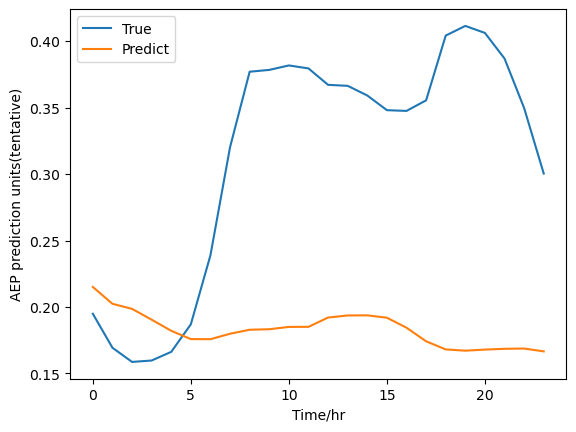

In [19]:
fig = plt.figure()
plt.plot(test_actual[0])
plt.plot(test_predict[0])
plt.xlabel('Time/hr')
plt.ylabel('AEP prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()


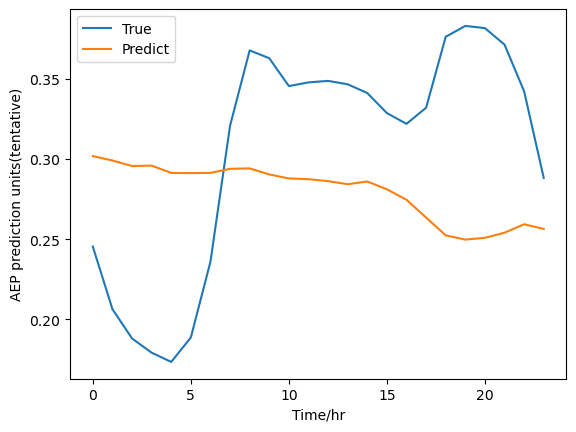

In [20]:
fig = plt.figure()
plt.plot(test_actual[1])
plt.plot(test_predict[1])
plt.xlabel('Time/hr')
plt.ylabel('AEP prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

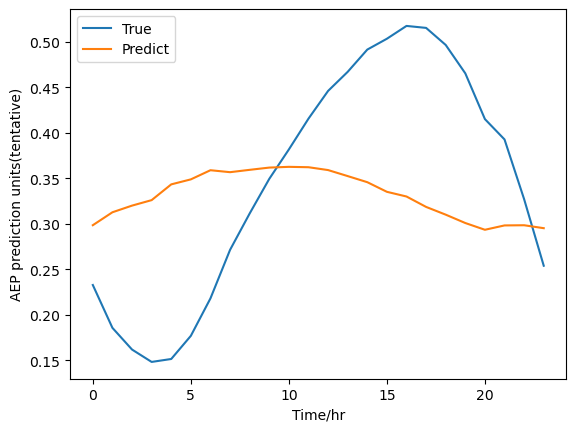

In [21]:
fig = plt.figure()
plt.plot(test_actual[200])
plt.plot(test_predict[200])
plt.xlabel('Time/hr')
plt.ylabel('AEP prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()